In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import warnings
#ignore warnings
warnings.filterwarnings('ignore') 

### Read train and test data csv

In [120]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [121]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [122]:
# Skewness has to be equal to 0, Kurtosis has to be equal to 3 for normal distribution
print('Skewness: %f' % df_train['SalePrice'].skew())
print('Kurtosis: %f' % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### Let's see on graph of data distribution in contrast with normal distribution

<Figure size 432x288 with 0 Axes>

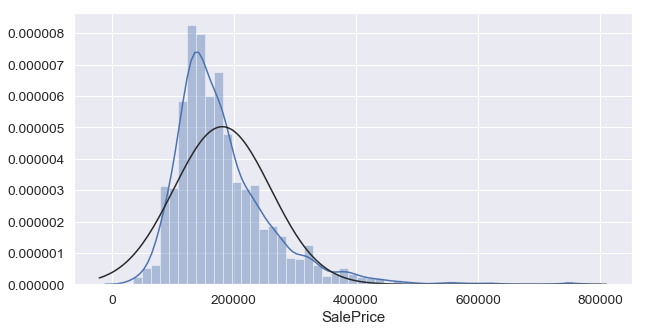

In [123]:
plt.subplots(figsize=(10, 5))
sns.distplot(df_train['SalePrice'], fit = norm)

### By making a graph of probabilities we considered the correctness of data distribution

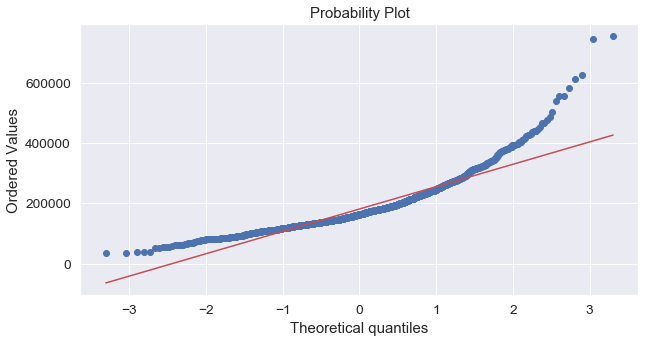

In [124]:
plt.subplots(figsize=(10, 5))
prob = stats.probplot(df_train['SalePrice'], plot=plt)

### To bring data closer to a normal distribution we are going to use logarithm

In [125]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

<Figure size 432x288 with 0 Axes>

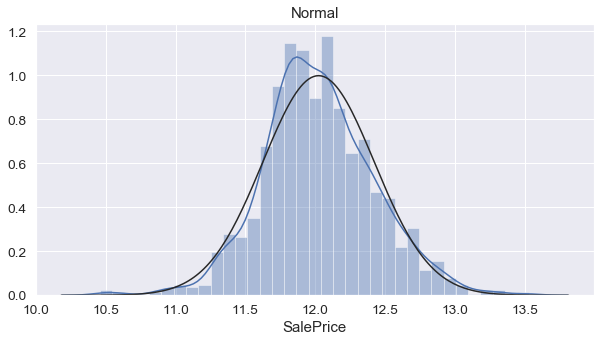

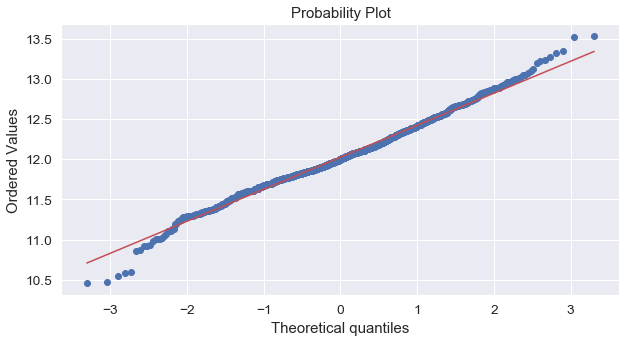

In [126]:
plt.figure(1)
plt.subplots(figsize=(10, 5))
sns.distplot(df_train['SalePrice'], fit = norm)
plt.title('Normal')
plt.figure(2)
plt.subplots(figsize=(10, 5))
prob = stats.probplot(df_train['SalePrice'], plot=plt)

### Nicely fitted, next we are going to plot the relationship of different predictors to each other

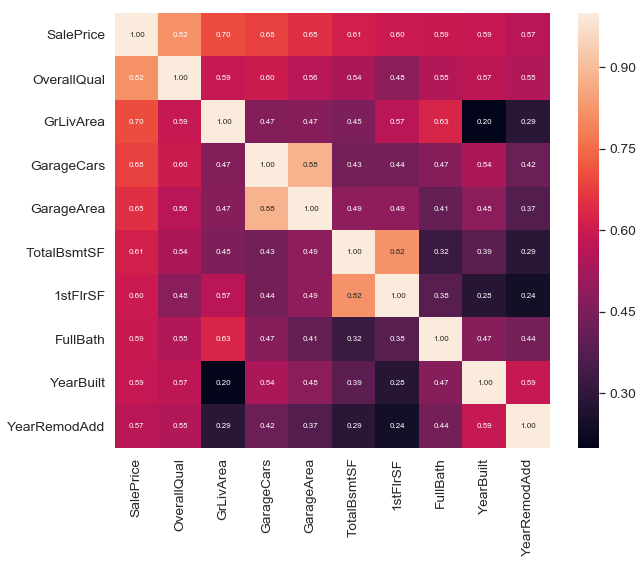

In [127]:
corrmat = df_train.corr()
plt.subplots(figsize=(10, 8))

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### By the given matrix above we are going to consider top 5 influencing predictors separately

### Qualititative predictors:

Text(0.5, 0, 'GrLivArea')

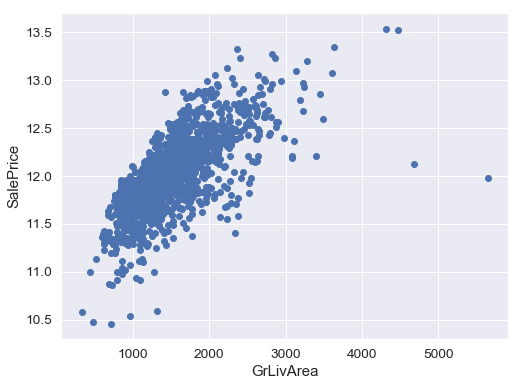

In [128]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
plt.subplots(figsize=(8, 6))
plt.scatter(x='GrLivArea', y="SalePrice", data=data)
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')

Text(0.5, 0, 'TotalBsmtSF')

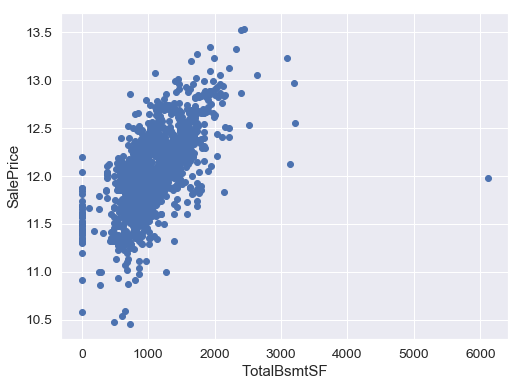

In [129]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
plt.subplots(figsize=(8, 6))
plt.scatter(x='TotalBsmtSF', y="SalePrice", data=data)
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')

Text(0.5, 0, 'GarageArea')

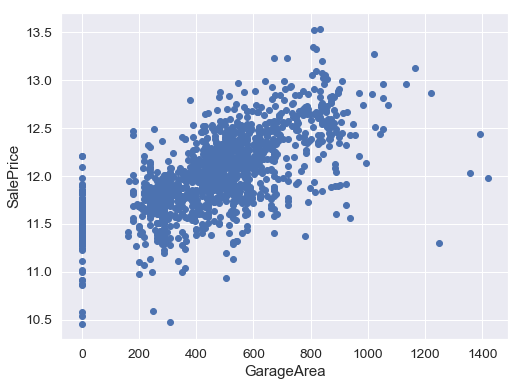

In [130]:
data = pd.concat([df_train['SalePrice'], df_train['GarageArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x='GarageArea', y="SalePrice", data=data)
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')

### Last two predictors we considered as quantitative:

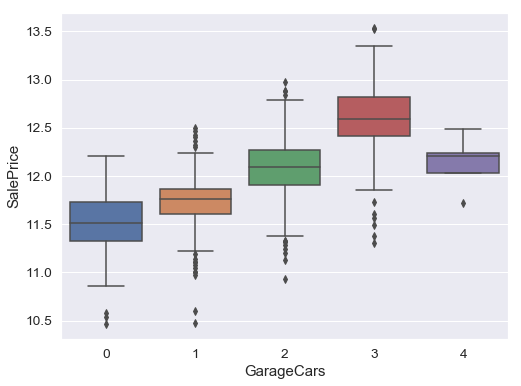

In [131]:
data = pd.concat([df_train['SalePrice'], df_train['GarageCars']], axis=1)
plt.subplots(figsize=(8, 6))
sns.boxplot(x='GarageCars', y="SalePrice", data=data)

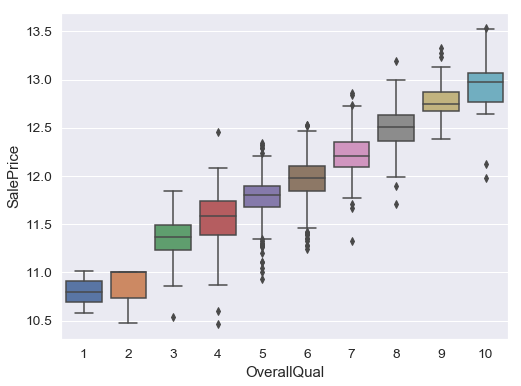

In [132]:
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
plt.subplots(figsize=(8, 6))
sns.boxplot(x='OverallQual', y="SalePrice", data=data)

#### By last two plots of predictors we can see that there is a straight dependency between them and SalePrice

### Union train and test into one general set to handle missing values

In [133]:
df_all = pd.concat([df_train, df_test])
df_all = df_all.drop(columns= ['SalePrice', 'Id'])
df_all.shape

(2919, 79)

# Missing values handling

In [134]:
total = df_all.isnull().sum().sort_values(ascending=False)
missing_data = pd.DataFrame({'Total': total})
missing_data = missing_data[missing_data['Total'] > 0]
missing_data


,Total
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageYrBlt,159
GarageCond,159


### We are going to handle missing values by using dummies

In [135]:
df_all = pd.get_dummies(df_all)

In [136]:
df_all = df_all.fillna(df_all.mean())
# and check
df_all.isnull().sum().max()

0

# Modeling

### Now we divide general set back to test and train sets

In [137]:
X_train = df_all[:df_train.shape[0]]
X_test = df_all[df_train.shape[0]:]
y_train = df_train[['SalePrice']]

### In order to predict SalePrice we are going to use a linear regularization model - 'Ridge'

In [144]:
from sklearn.linear_model import Ridge
params = {'max_iter': 50000}
ridge = Ridge(**params)
est = GridSearchCV(ridge, param_grid={"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
# number of params:
num = 100
print("Chosen parameter on %d datapoints: %s" % (num,est.fit(X[:num], y[:num]).best_params_))

Chosen parameter on 100 datapoints: {'alpha': 10.0}


In [164]:
params = {'alpha': 10.0, 'max_iter': 50000}
ridge = Ridge(**params)
# k-fold cross validation
kFold = 10 # number of sections

### Evaluating with using k-fold cross validation

In [171]:
kf = KFold(n_splits=kFold, shuffle=True, random_state=2)
y_pr = np.zeros((X_train.shape[0],))

### Outputing RMSE score

In [189]:
for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_te = y_train.iloc[train_index], y_train.iloc[test_index]
    ridge.fit(X_tr, y_tr)
    #print(np.reshape(ridge.predict(X_te),-1))
    y_pr[test_index] = np.reshape(ridge.predict(X_te),-1) # in order to provide the same shape
err = sqrt(mean_squared_error(y_pr, y_train))
print("RMSE: %.5f" % err)

RMSE: 0.15178


### Prediction making:

In [221]:
y_pr = ridge.predict(X_test)
result = np.exp(y_pr)

In [227]:
result = np.reshape(result, -1) # in order to provide the same shape in submission creating

In [228]:
result

array([114679.01163113, 146743.18620445, 168858.09427926, ...,
       157673.63000212, 112621.92910472, 227533.38865638])

### Submission creation:

In [232]:
submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': result})
submission.to_csv("submission_ridge.csv", index=None)